## Dino Classification 

In [30]:
# 라이브러리 불러오기
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import timm
import numpy as np

# 기존 모델 파일들 정리
for file in ["photo_pretrained_dino.pth", "best_photo_model.pth", "best_drawing_model.pth"]:
    if os.path.exists(file):
        os.remove(file)
        print(f"🗑️ {file} 삭제됨")
        
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📌 사용 중인 디바이스: {device}")

🗑️ photo_pretrained_dino.pth 삭제됨
📌 사용 중인 디바이스: cuda


In [31]:
# 하이퍼파라미터
BATCH_SIZE = 16
LR_PHOTO = 1e-4
LR_DRAWING = 1e-5
EPOCHS_PHOTO = 15
EPOCHS_DRAWING = 30

In [32]:
# 224x224 전처리 (DINOv2 최적화)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 로드
photo_dataset_train = datasets.ImageFolder('dataset/photo', transform=transform_train)
photo_dataset_val = datasets.ImageFolder('dataset/photo', transform=transform_val)
drawing_dataset_train = datasets.ImageFolder('dataset/drawing', transform=transform_train)
drawing_dataset_val = datasets.ImageFolder('dataset/drawing', transform=transform_val)

# train/val 나누기 (일관된 분할)
def split_dataset_consistent(dataset_train, dataset_val):
    total_size = len(dataset_train)
    train_size = int(0.8 * total_size)
    val_size = total_size - train_size
    
    generator = torch.Generator().manual_seed(42)
    train_indices, val_indices = random_split(range(total_size), [train_size, val_size], generator=generator)
    
    train_subset = torch.utils.data.Subset(dataset_train, train_indices.indices)
    val_subset = torch.utils.data.Subset(dataset_val, val_indices.indices)
    
    return train_subset, val_subset

photo_train, photo_val = split_dataset_consistent(photo_dataset_train, photo_dataset_val)
drawing_train, drawing_val = split_dataset_consistent(drawing_dataset_train, drawing_dataset_val)

# 데이터 로더
photo_train_loader = DataLoader(photo_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
photo_val_loader = DataLoader(photo_val, batch_size=BATCH_SIZE, num_workers=4)
drawing_train_loader = DataLoader(drawing_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
drawing_val_loader = DataLoader(drawing_val, batch_size=BATCH_SIZE, num_workers=4)

print(f"📊 데이터셋 크기:")
print(f"사진 - 학습: {len(photo_train)}, 검증: {len(photo_val)}")
print(f"그림 - 학습: {len(drawing_train)}, 검증: {len(drawing_val)}")
print(f"클래스: {photo_dataset_train.classes}")

📊 데이터셋 크기:
사진 - 학습: 5756, 검증: 1440
그림 - 학습: 654, 검증: 164
클래스: ['angry', 'fear', 'happy', 'sadness']


** 아래 코드 자주입력하면 밴됨 -> 터미널에서 토큰 엑세스 해야됨

터미널에서 입력 : huggingface-cli login  
토큰 입력 : ######

In [33]:
# 데이터 로더
photo_train_loader = DataLoader(photo_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
photo_val_loader = DataLoader(photo_val, batch_size=BATCH_SIZE, num_workers=4)
drawing_train_loader = DataLoader(drawing_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
drawing_val_loader = DataLoader(drawing_val, batch_size=BATCH_SIZE, num_workers=4)

print(f"📊 데이터셋 크기:")
print(f"사진 - 학습: {len(photo_train)}, 검증: {len(photo_val)}")
print(f"그림 - 학습: {len(drawing_train)}, 검증: {len(drawing_val)}")
print(f"클래스: {photo_dataset_train.classes}")

# 224x224 DINOv2 분류기
class DinoClassifier(nn.Module):
    def __init__(self, model_name='vit_small_patch14_dinov2.lvd142m', num_classes=4):
        super().__init__()
        # 224x224 기본 크기로 모델 생성
        self.backbone = timm.create_model(model_name, pretrained=True, img_size=224)
        self.backbone.reset_classifier(0)
        
        # 개선된 분류 헤드
        self.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.backbone.num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)

# 모델 초기화
model = DinoClassifier(num_classes=len(photo_dataset_train.classes)).to(device)
print(f"📊 모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

📊 데이터셋 크기:
사진 - 학습: 5756, 검증: 1440
그림 - 학습: 654, 검증: 164
클래스: ['angry', 'fear', 'happy', 'sadness']


📊 모델 파라미터 수: 21,728,388


In [34]:
# 손실함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR_PHOTO, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_PHOTO)

# 학습 함수
def train_epoch(model, loader, optimizer, criterion, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        if batch_idx % 20 == 0:
            print(f'  배치 [{batch_idx}/{len(loader)}] 손실: {loss.item():.4f} 정확도: {100.*correct/total:.2f}%')
    
    if scheduler:
        scheduler.step()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# 평가 함수
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [35]:
# Step 1 - 사진 데이터로 사전 학습
print("\n🔵 Step 1: 사람 얼굴 이미지로 사전 학습")
print("=" * 50)

best_val_acc = 0
patience = 5
patience_counter = 0

for epoch in range(EPOCHS_PHOTO):
    print(f"\n에포크 [{epoch+1}/{EPOCHS_PHOTO}]")
    
    # 학습
    train_loss, train_acc = train_epoch(model, photo_train_loader, optimizer, criterion, scheduler)
    
    # 검증
    val_loss, val_acc = evaluate_model(model, photo_val_loader, criterion)
    
    print(f"학습 - 손실: {train_loss:.4f}, 정확도: {train_acc:.2f}%")
    print(f"검증 - 손실: {val_loss:.4f}, 정확도: {val_acc:.2f}%")
    print(f"학습률: {optimizer.param_groups[0]['lr']:.6f}")
    
    # 조기 종료 체크
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_photo_model.pth")
        patience_counter = 0
        print("✅ 최고 성능 모델 저장!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏰ 조기 종료")
            break

print(f"\n✅ Step 1 완료 - 최고 검증 정확도: {best_val_acc:.2f}%")

# 최고 성능 모델 로드
model.load_state_dict(torch.load("best_photo_model.pth"))


🔵 Step 1: 사람 얼굴 이미지로 사전 학습

에포크 [1/15]
  배치 [0/360] 손실: 1.3425 정확도: 31.25%
  배치 [20/360] 손실: 1.4899 정확도: 23.21%
  배치 [40/360] 손실: 1.3316 정확도: 24.70%
  배치 [60/360] 손실: 1.4577 정확도: 24.59%
  배치 [80/360] 손실: 1.4642 정확도: 24.61%
  배치 [100/360] 손실: 1.3352 정확도: 24.69%
  배치 [120/360] 손실: 1.3732 정확도: 24.85%
  배치 [140/360] 손실: 1.3617 정확도: 24.91%
  배치 [160/360] 손실: 1.3063 정확도: 25.12%
  배치 [180/360] 손실: 1.3355 정확도: 25.00%
  배치 [200/360] 손실: 1.3781 정확도: 25.03%
  배치 [220/360] 손실: 1.3482 정확도: 24.83%
  배치 [240/360] 손실: 1.3985 정확도: 25.03%
  배치 [260/360] 손실: 1.3717 정확도: 24.90%
  배치 [280/360] 손실: 1.3961 정확도: 25.00%
  배치 [300/360] 손실: 1.4005 정확도: 24.92%
  배치 [320/360] 손실: 1.3943 정확도: 25.06%
  배치 [340/360] 손실: 1.4220 정확도: 25.09%
학습 - 손실: 1.4181, 정확도: 25.14%
검증 - 손실: 1.3868, 정확도: 25.42%
학습률: 0.000099
✅ 최고 성능 모델 저장!

에포크 [2/15]
  배치 [0/360] 손실: 1.3817 정확도: 31.25%
  배치 [20/360] 손실: 1.3888 정확도: 27.98%
  배치 [40/360] 손실: 1.3705 정확도: 26.52%
  배치 [60/360] 손실: 1.4061 정확도: 25.31%
  배치 [80/360] 손실: 1.3555 정확도: 24.31%

<All keys matched successfully>

In [36]:
# Step 2 - 그림으로 파인튜닝
print("\n🟣 Step 2: 그림 이미지로 파인튜닝")
print("=" * 50)

# 헤드만 학습 (백본 동결)
for name, param in model.named_parameters():
    if 'head' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer_ft = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=LR_DRAWING, 
    weight_decay=0.01
)
scheduler_ft = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=EPOCHS_DRAWING)

best_drawing_acc = 0
patience_counter = 0

for epoch in range(EPOCHS_DRAWING):
    print(f"\n에포크 [{epoch+1}/{EPOCHS_DRAWING}]")
    
    # 15에포크 후 백본 일부 언프리징
    if epoch == 15:
        print("🔓 백본 일부 언프리징!")
        for name, param in model.backbone.named_parameters():
            if 'blocks.10' in name or 'blocks.11' in name or 'norm' in name:
                param.requires_grad = True
        
        optimizer_ft = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()), 
            lr=LR_DRAWING/2,
            weight_decay=0.01
        )
    
    # 학습
    train_loss, train_acc = train_epoch(model, drawing_train_loader, optimizer_ft, criterion, scheduler_ft)
    
    # 검증
    val_loss, val_acc = evaluate_model(model, drawing_val_loader, criterion)
    
    print(f"학습 - 손실: {train_loss:.4f}, 정확도: {train_acc:.2f}%")
    print(f"검증 - 손실: {val_loss:.4f}, 정확도: {val_acc:.2f}%")
    
    # 최고 성능 모델 저장
    if val_acc > best_drawing_acc:
        best_drawing_acc = val_acc
        torch.save(model.state_dict(), "best_drawing_model.pth")
        patience_counter = 0
        print("✅ 최고 성능 모델 저장!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏰ 조기 종료")
            break

print(f"\n✅ Step 2 완료 - 최고 검증 정확도: {best_drawing_acc:.2f}%")


🟣 Step 2: 그림 이미지로 파인튜닝

에포크 [1/30]


  배치 [0/41] 손실: 1.3965 정확도: 6.25%
  배치 [20/41] 손실: 1.4028 정확도: 26.49%
  배치 [40/41] 손실: 1.4194 정확도: 24.62%
학습 - 손실: 1.3867, 정확도: 24.62%
검증 - 손실: 1.3851, 정확도: 32.93%
✅ 최고 성능 모델 저장!

에포크 [2/30]
  배치 [0/41] 손실: 1.4117 정확도: 18.75%
  배치 [20/41] 손실: 1.3700 정확도: 20.54%
  배치 [40/41] 손실: 1.4047 정확도: 22.78%
학습 - 손실: 1.3922, 정확도: 22.78%
검증 - 손실: 1.3839, 정확도: 31.10%

에포크 [3/30]
  배치 [0/41] 손실: 1.4119 정확도: 12.50%
  배치 [20/41] 손실: 1.4225 정확도: 22.62%
  배치 [40/41] 손실: 1.4112 정확도: 25.23%
학습 - 손실: 1.3893, 정확도: 25.23%
검증 - 손실: 1.3826, 정확도: 28.66%

에포크 [4/30]
  배치 [0/41] 손실: 1.3802 정확도: 25.00%
  배치 [20/41] 손실: 1.3854 정확도: 25.89%
  배치 [40/41] 손실: 1.3886 정확도: 24.62%
학습 - 손실: 1.3869, 정확도: 24.62%
검증 - 손실: 1.3818, 정확도: 29.27%

에포크 [5/30]
  배치 [0/41] 손실: 1.3852 정확도: 37.50%
  배치 [20/41] 손실: 1.4086 정확도: 24.40%
  배치 [40/41] 손실: 1.3808 정확도: 25.54%
학습 - 손실: 1.3894, 정확도: 25.54%
검증 - 손실: 1.3811, 정확도: 27.44%

에포크 [6/30]
  배치 [0/41] 손실: 1.3700 정확도: 31.25%
  배치 [20/41] 손실: 1.3926 정확도: 26.79%
  배치 [40/41] 손실: 1.3518 정확도: 2

In [37]:
# 최종 모델 로드
model.load_state_dict(torch.load("best_drawing_model.pth"))

# 상세 성능 평가
def detailed_evaluate(model, loader, target_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    print(classification_report(all_labels, all_preds, target_names=target_names))
    return all_preds, all_labels

print("\n📊 최종 성능 평가")
print("=" * 50)
print("🎨 그림 데이터 최종 성능:")
preds, labels = detailed_evaluate(model, drawing_val_loader, drawing_dataset_train.classes)


📊 최종 성능 평가
🎨 그림 데이터 최종 성능:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        41
        fear       0.36      0.80      0.49        54
       happy       0.14      0.04      0.06        24
         sad       0.28      0.22      0.25        45

    accuracy                           0.33       164
   macro avg       0.19      0.27      0.20       164
weighted avg       0.21      0.33      0.24       164



/workspace/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspace/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspace/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


🎨 그림 데이터 예측 결과 시각화


/tmp/ipykernel_27520/662533695.py:76: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_27520/662533695.py:76: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_27520/662533695.py:76: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_27520/662533695.py:76: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_27520/662533695.py:76: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_27520/662533695.py:76: UserWarning: Glyph 47280 (\N{HANGUL SYLLABLE ROE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_27520/662533695.py:76: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_lay

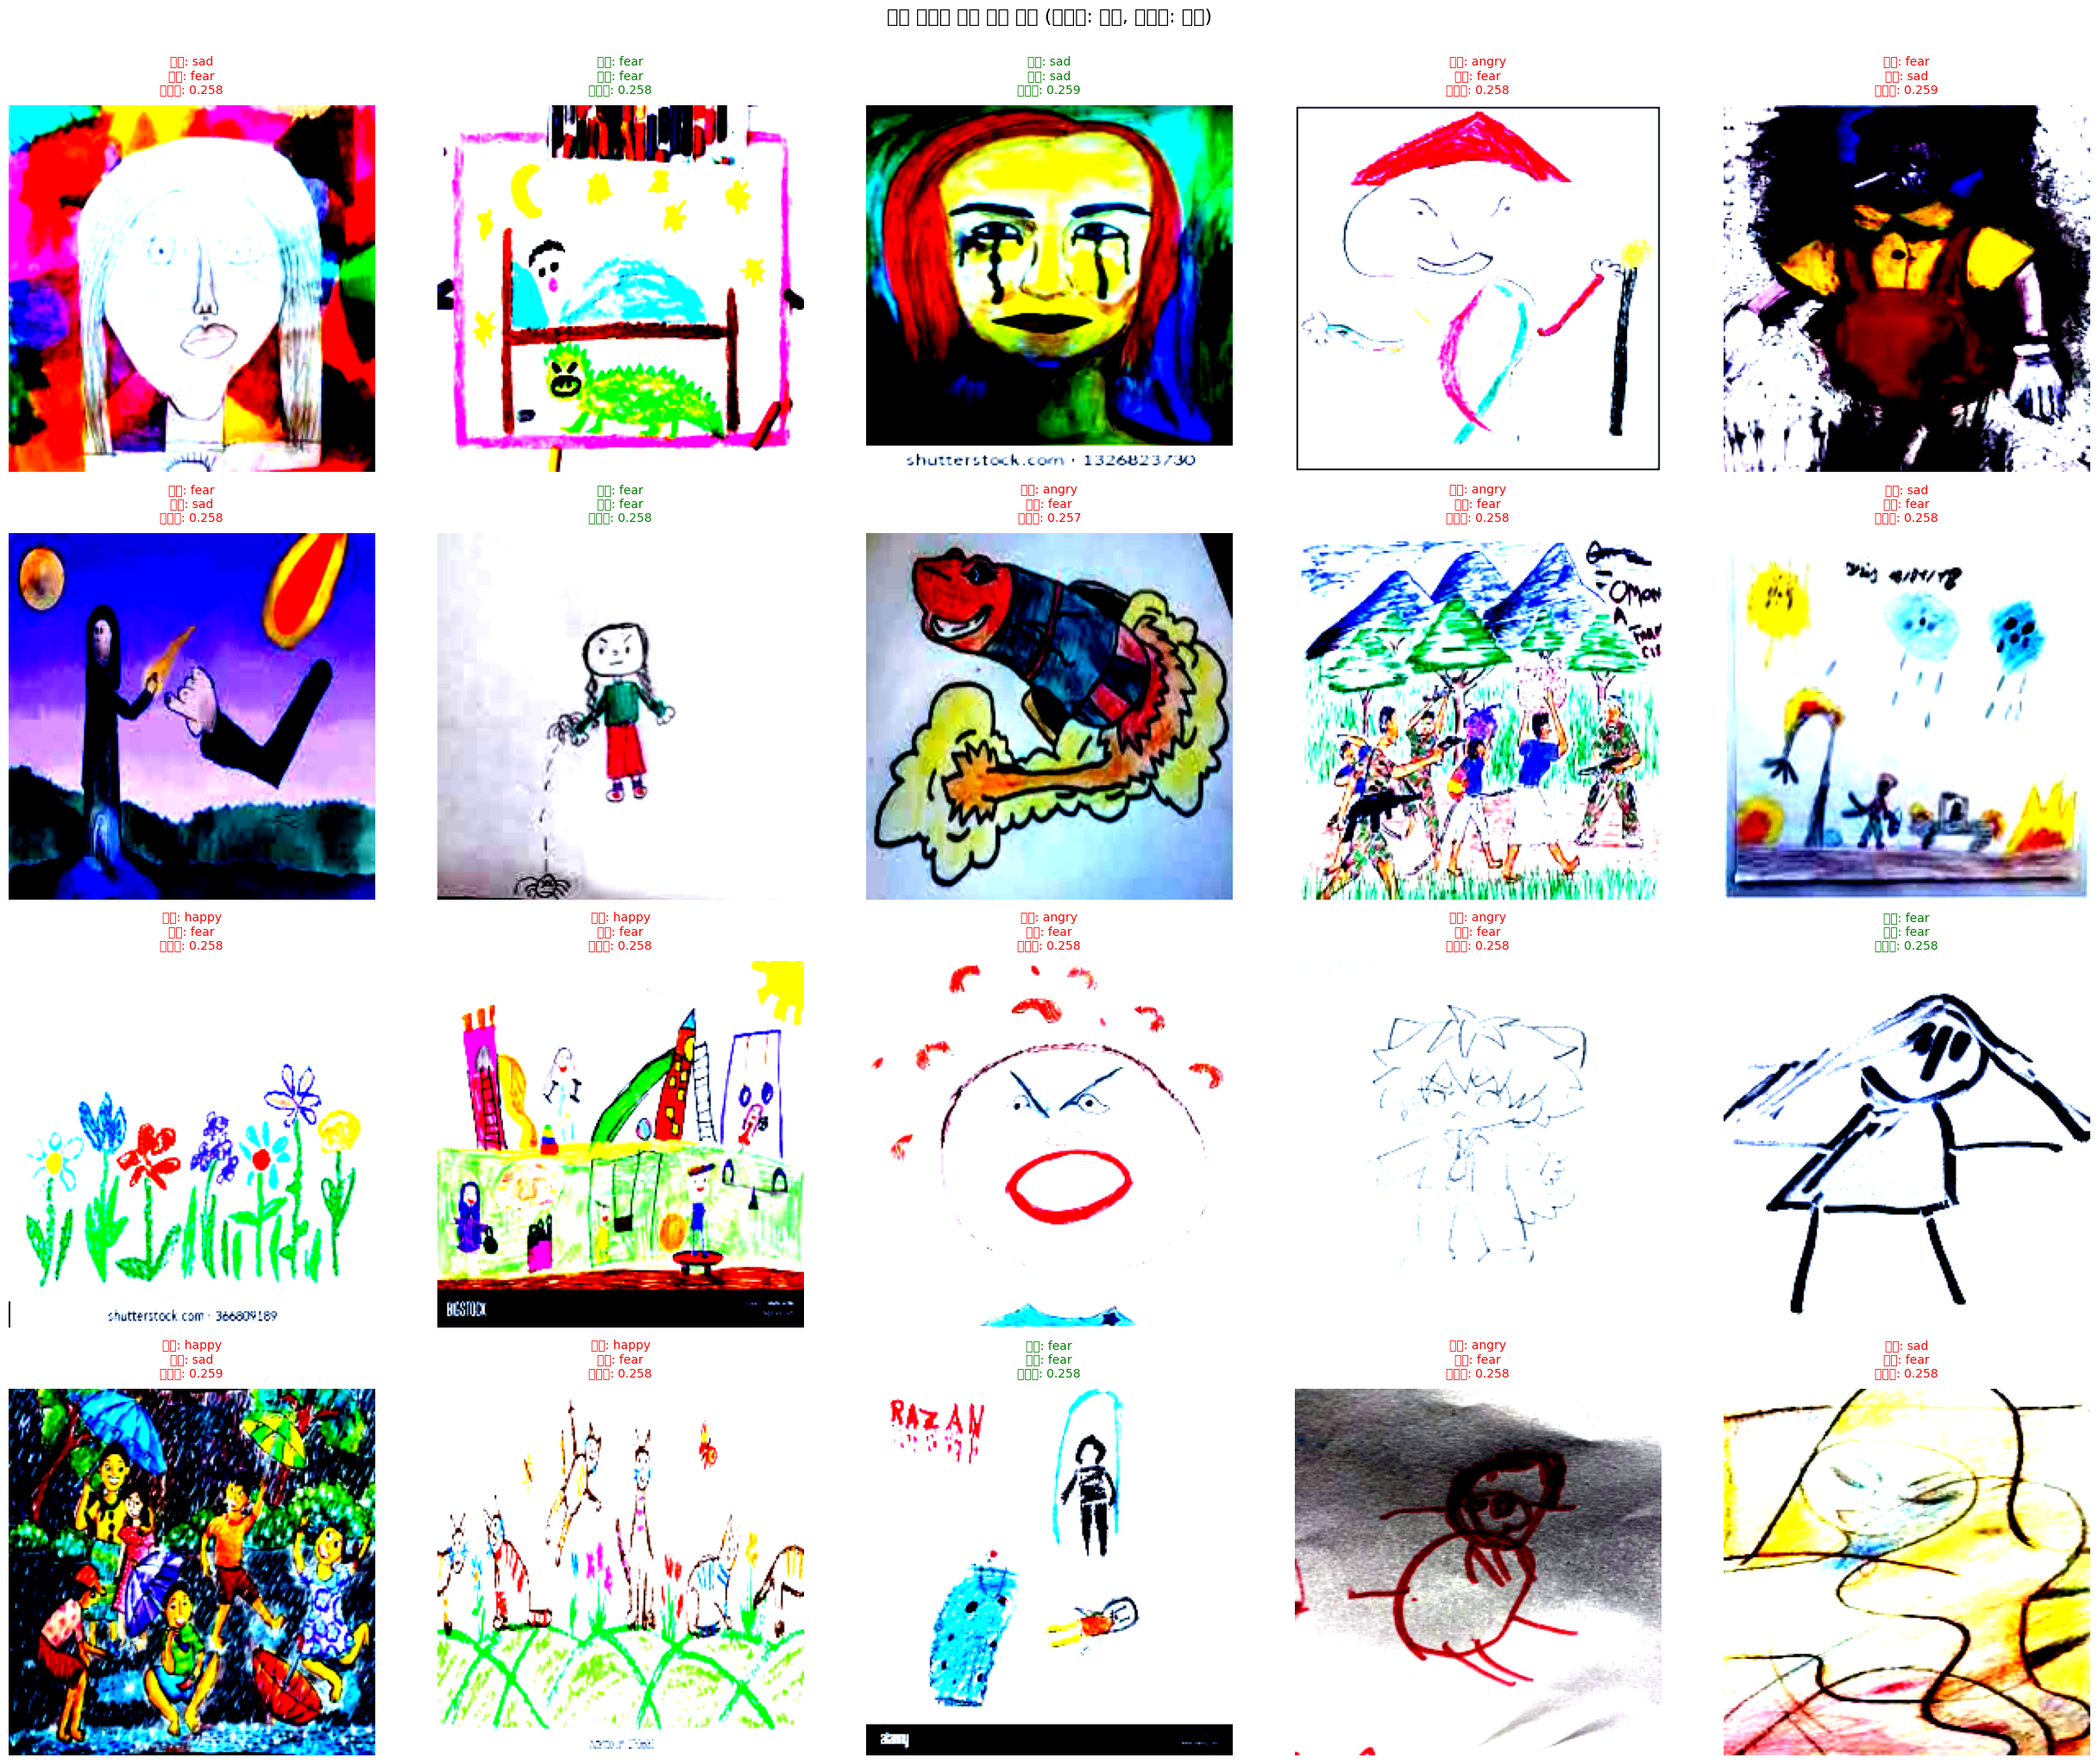


📊 샘플 예측 결과:
총 샘플 수: 20
정답 수: 5
정확도: 25.00%

📈 클래스별 예측 성능:
------------------------------------------------------------
angry           | 정확도:  0.0% (0/6) | 평균 신뢰도: 0.258
fear            | 정확도: 66.7% (4/6) | 평균 신뢰도: 0.258
happy           | 정확도:  0.0% (0/4) | 평균 신뢰도: 0.258
sad             | 정확도: 25.0% (1/4) | 평균 신뢰도: 0.258

🔍 오답 사례 분석


/workspace/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspace/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47168 (\N{HANGUL SYLLABLE RYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspace/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspace/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspace/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  fig.canva

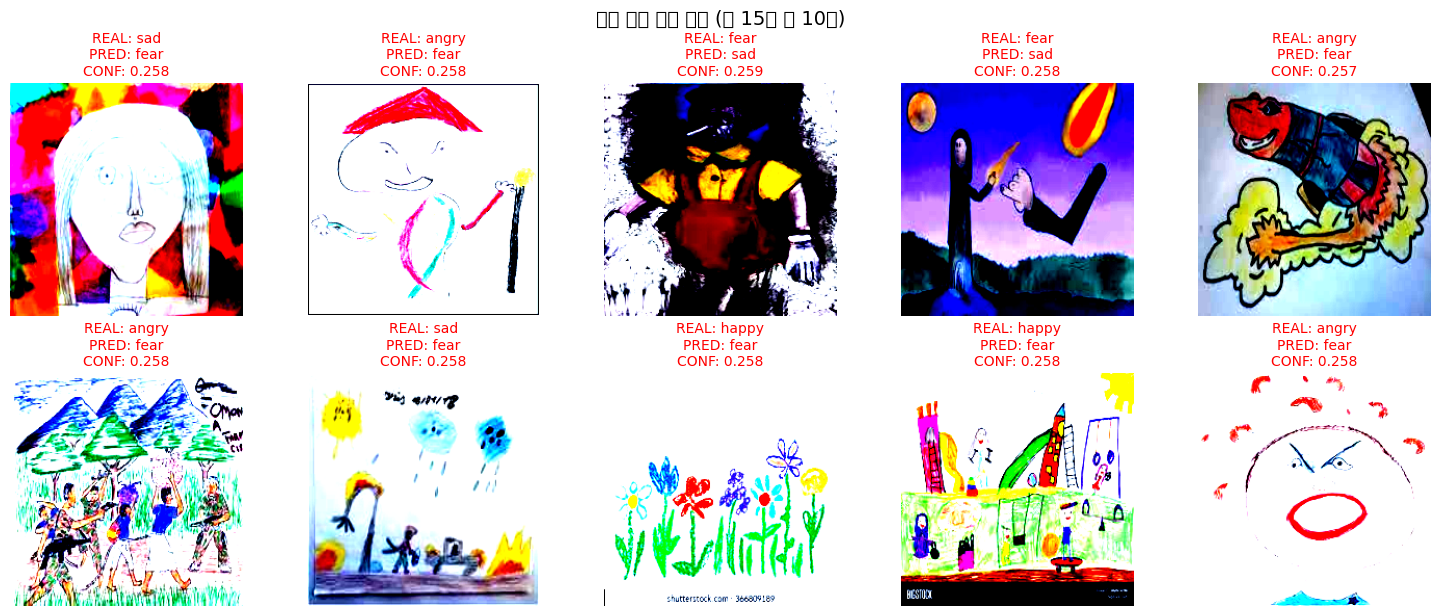

In [38]:
# 필요한 라이브러리 추가 import
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 그림 예측 결과 시각화 함수
def visualize_predictions(model, dataset, class_names, num_samples=20, figsize=(20, 16)):
    """
    validation 데이터에서 샘플을 뽑아 실제 vs 예측 결과를 시각화
    """
    model.eval()
    
    # 랜덤 샘플 선택
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # 결과 저장할 리스트
    results = []
    
    with torch.no_grad():
        for idx in indices:
            image, true_label = dataset[idx]
            
            # 배치 차원 추가하고 디바이스로 이동
            image_batch = image.unsqueeze(0).to(device)
            
            # 예측
            output = model(image_batch)
            pred_label = output.argmax(dim=1).item()
            confidence = torch.softmax(output, dim=1)[0][pred_label].item()
            
            # 결과 저장
            results.append({
                'image': image,
                'true_label': true_label,
                'pred_label': pred_label,
                'true_class': class_names[true_label],
                'pred_class': class_names[pred_label],
                'confidence': confidence,
                'correct': true_label == pred_label
            })
    
    # 시각화
    rows = (num_samples + 4) // 5  # 한 줄에 5개씩
    cols = min(5, num_samples)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, result in enumerate(results):
        row = i // cols
        col = i % cols
        
        # 이미지 텐서를 numpy로 변환 (C, H, W) -> (H, W, C)
        img_np = result['image'].permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)  # 값 범위 조정
        
        axes[row, col].imshow(img_np)
        axes[row, col].axis('off')
        
        # 제목 설정 (정답 여부에 따라 색상 변경)
        title_color = 'green' if result['correct'] else 'red'
        title = f"실제: {result['true_class']}\n예측: {result['pred_class']}\n신뢰도: {result['confidence']:.3f}"
        
        axes[row, col].set_title(title, fontsize=10, color=title_color, pad=10)
    
    # 빈 subplot 제거
    for i in range(len(results), rows * cols):
        row = i // cols
        col = i % cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.suptitle('그림 데이터 예측 결과 비교 (초록색: 정답, 빨간색: 오답)', 
                fontsize=16, y=1.02)
    plt.show()
    
    # 정확도 통계 출력
    correct_count = sum(1 for r in results if r['correct'])
    accuracy = correct_count / len(results)
    print(f"\n📊 샘플 예측 결과:")
    print(f"총 샘플 수: {len(results)}")
    print(f"정답 수: {correct_count}")
    print(f"정확도: {accuracy:.2%}")
    
    return results

# 클래스별 예측 결과 분석 함수
def analyze_class_predictions(results, class_names):
    """
    클래스별 예측 성능 분석
    """
    class_stats = {name: {'correct': 0, 'total': 0, 'avg_confidence': 0} for name in class_names}
    
    for result in results:
        true_class = result['true_class']
        class_stats[true_class]['total'] += 1
        if result['correct']:
            class_stats[true_class]['correct'] += 1
    
    # 클래스별 신뢰도 계산
    for result in results:
        true_class = result['true_class']
        class_stats[true_class]['avg_confidence'] += result['confidence']
    
    for class_name in class_names:
        if class_stats[class_name]['total'] > 0:
            class_stats[class_name]['avg_confidence'] /= class_stats[class_name]['total']
    
    print("\n📈 클래스별 예측 성능:")
    print("-" * 60)
    for class_name in class_names:
        stats = class_stats[class_name]
        if stats['total'] > 0:
            accuracy = stats['correct'] / stats['total']
            print(f"{class_name:15} | 정확도: {accuracy:5.1%} ({stats['correct']}/{stats['total']}) | "
                  f"평균 신뢰도: {stats['avg_confidence']:.3f}")

# 실행 코드
print("🎨 그림 데이터 예측 결과 시각화")
print("=" * 50)

# 시각화 실행 (20장 샘플)
prediction_results = visualize_predictions(
    model=model, 
    dataset=drawing_val, 
    class_names=drawing_dataset.classes, 
    num_samples=20,
    figsize=(25, 20)
)

# 클래스별 분석
analyze_class_predictions(prediction_results, drawing_dataset.classes)

# 오답 사례만 따로 시각화하는 함수
def visualize_incorrect_predictions(results, max_samples=10):
    """
    오답 예측 사례만 따로 시각화
    """
    incorrect_results = [r for r in results if not r['correct']]
    
    if not incorrect_results:
        print("🎉 모든 예측이 정답입니다!")
        return
    
    num_show = min(len(incorrect_results), max_samples)
    
    if num_show == 0:
        return
        
    rows = (num_show + 4) // 5
    cols = min(5, num_show)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
    if rows == 1:
        axes = axes.reshape(1, -1) if num_show > 1 else [axes]
    
    for i, result in enumerate(incorrect_results[:num_show]):
        row = i // cols
        col = i % cols
        
        img_np = result['image'].permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)
        
        axes[row][col].imshow(img_np)
        axes[row][col].axis('off')
        
        title = f"REAL: {result['true_class']}\nPRED: {result['pred_class']}\nCONF: {result['confidence']:.3f}"
        axes[row][col].set_title(title, fontsize=10, color='red')
    
    # 빈 subplot 제거
    for i in range(num_show, rows * cols):
        row = i // cols
        col = i % cols
        if rows > 1:
            fig.delaxes(axes[row][col])
        else:
            fig.delaxes(axes[col])
    
    plt.tight_layout()
    plt.suptitle(f'오답 예측 사례 분석 (총 {len(incorrect_results)}개 중 {num_show}개)', 
                fontsize=14, y=1.02)
    plt.show()

# 오답 사례 시각화 실행
print("\n🔍 오답 사례 분석")
visualize_incorrect_predictions(prediction_results, max_samples=10)